In [46]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, log_loss, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner as kt
from keras_tuner import HyperParameters

### <span style="color:chocolate"></span> Load Data, Add binary popularity column, set genre

In [47]:
# Load the data from a CSV file into a pandas dataframe.
data_init = pd.read_csv(
    'spotify_data.csv',
    sep=',', encoding='latin-1')
data_init.drop(columns='Unnamed: 0', inplace=True)

# Calculate medians by genre
genre_medians = data_init.groupby('genre')['popularity'].transform('median')

# Add binary indicator for popularity by genre. 1 if popularity is greater than the median, 0 otherwise.
data_init['popular'] = np.where(data_init['popularity'] >= data_init.groupby('genre')['popularity'].transform('median'), 1, 0)

---
### <span style="color:chocolate"></span> EDA

In [48]:
# Choose a genre to analyze.
data = data_init[data_init['genre'].isin(['piano'])]
data.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popular
39882,Chris Springer,Open Our Eyes,56AfIdppVQ2lL9qaDZt1ju,52,2012,piano,0.303,0.01620,6,-31.287,1,0.0557,0.989000,0.920000,0.1170,0.209,168.211,116619,3,1
39883,The Fray,Be Still,3URt4lJQlANOstDBAWQJA7,53,2012,piano,0.361,0.14900,7,-12.066,1,0.0333,0.887000,0.000000,0.1750,0.302,107.607,168853,3,1
39884,Secondhand Serenade,Fall for You (Acoustic),5V7mTIcXVU9k2JNu0mE6vy,61,2012,piano,0.433,0.30700,0,-8.796,1,0.0327,0.650000,0.000000,0.0635,0.378,178.114,176947,4,1
39885,The Fray,Heartbeat,2atYprr9JsQaLynGhrWhld,50,2012,piano,0.458,0.82100,9,-5.076,1,0.0334,0.000594,0.000095,0.1610,0.323,144.460,220693,4,1
39886,Chris Springer,I Love You Lord,4awQIodDfE1pM4Xmljo5JP,48,2012,piano,0.294,0.00678,6,-30.955,1,0.0386,0.993000,0.926000,0.0789,0.177,66.371,158189,4,1


In [49]:
data.isnull().sum()

artist_name         0
track_name          0
track_id            0
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
popular             0
dtype: int64

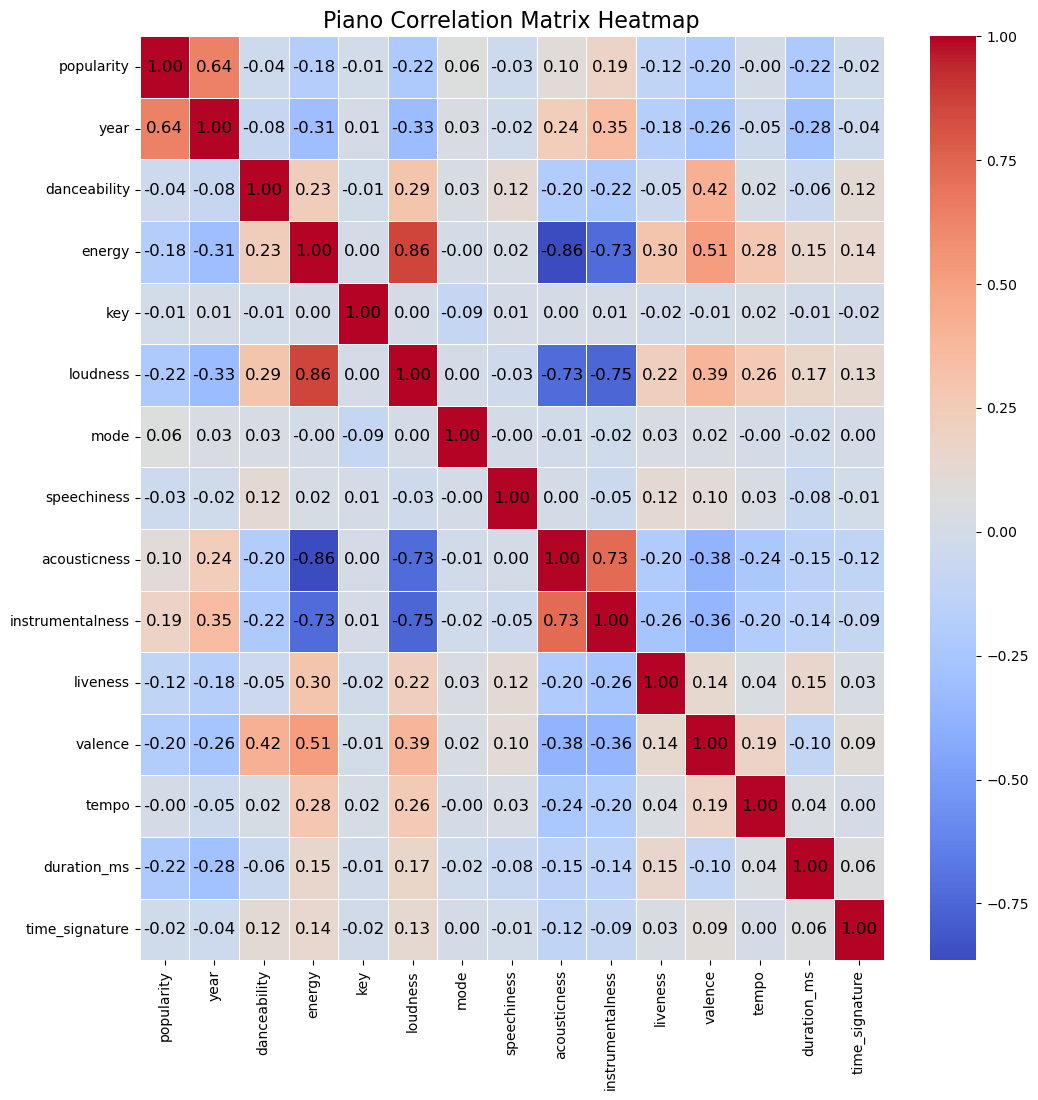

In [50]:
# Drop unnecessary columns for correlation
data_corr = data.drop(columns=['popular', 'artist_name', 'track_name', 'track_id', 'genre']) 

# Calculate the correlation matrix
corr = data_corr.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr,
    annot=False,            # Turn off default annotations
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)

# Annotate each cell manually
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(
            j + 0.5, i + 0.5,  # Adjust position for each cell
            f"{corr.iloc[i, j]:.2f}",  # Format to 2 decimal places
            ha='center', va='center', color='black', fontsize=12
        )

plt.title('Piano Correlation Matrix Heatmap', fontsize=16)
plt.show()

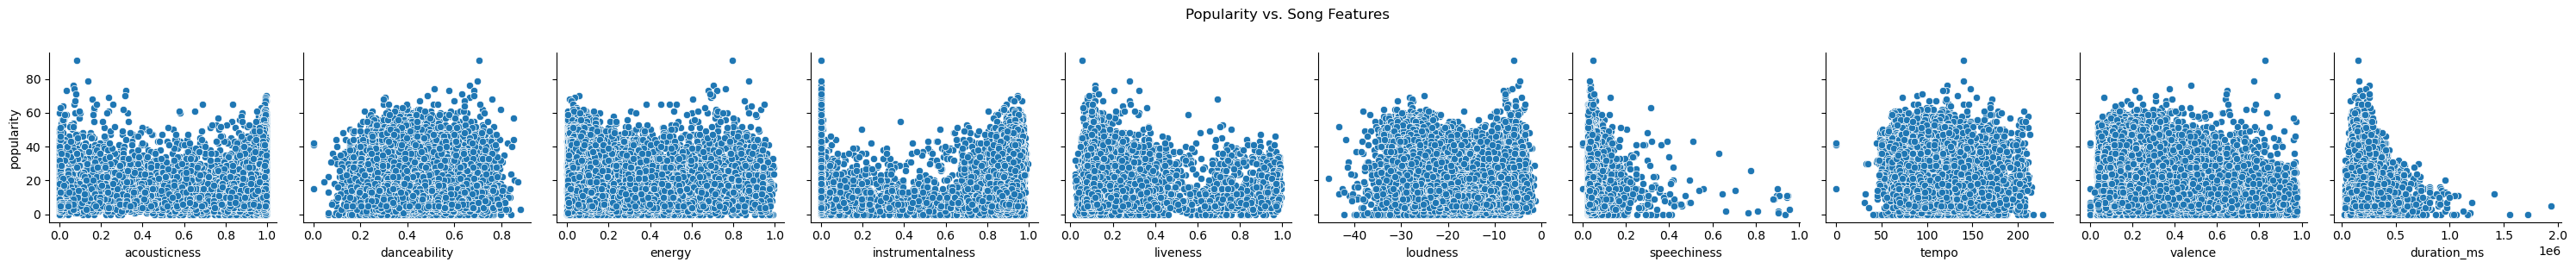

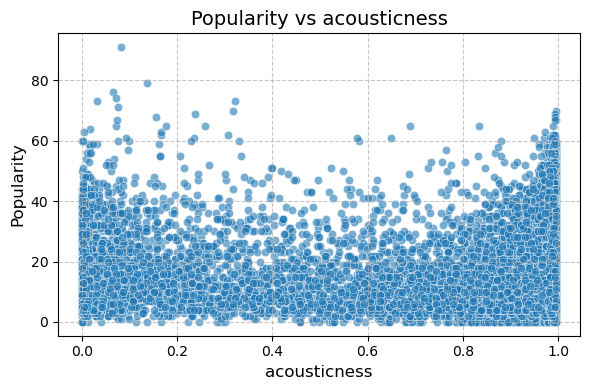

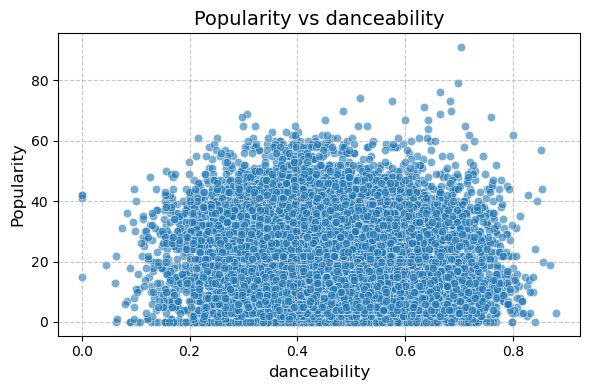

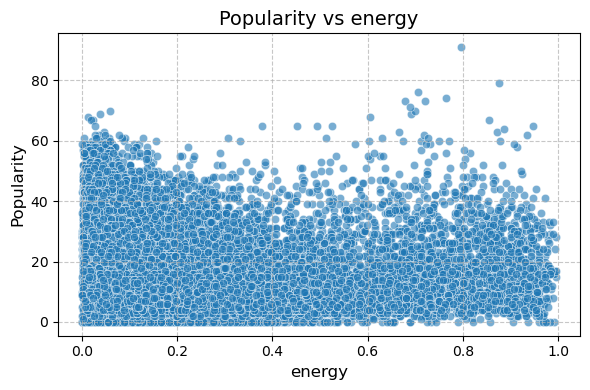

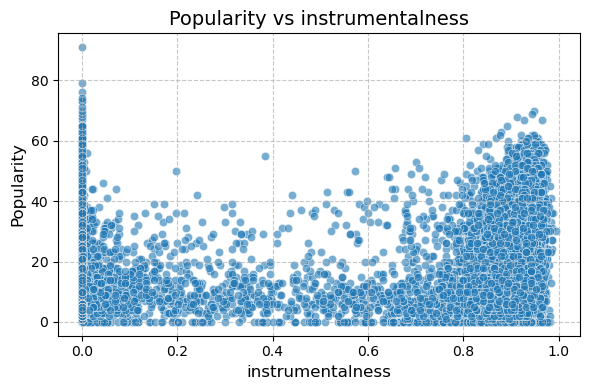

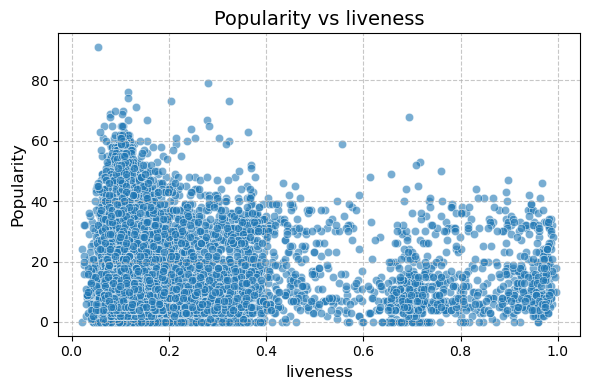

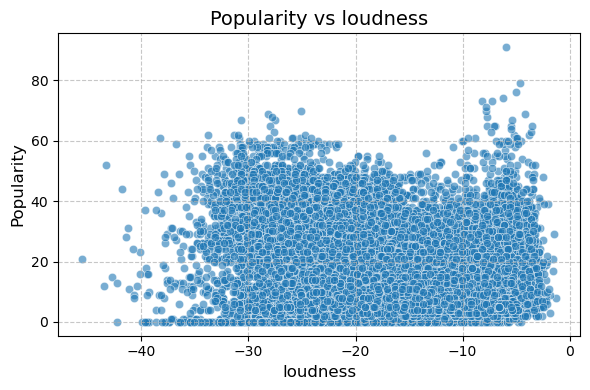

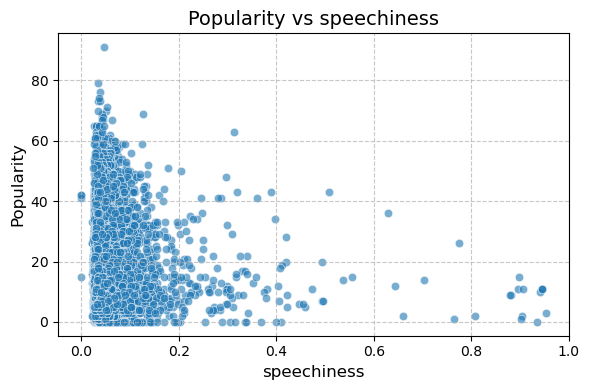

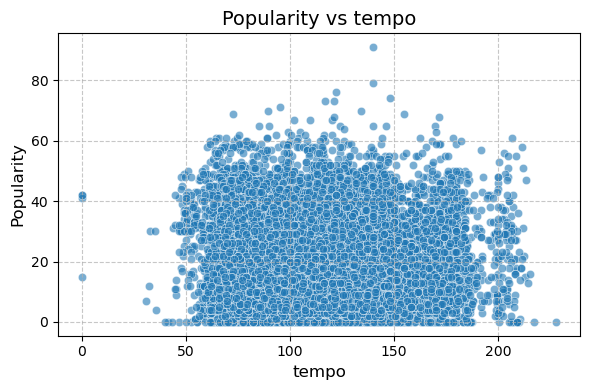

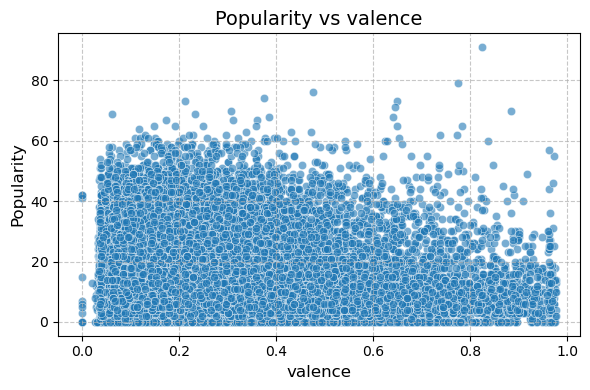

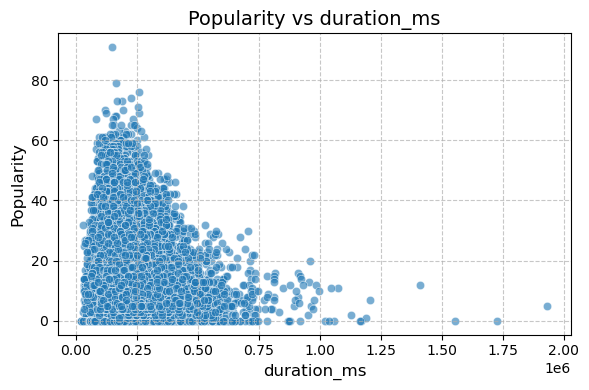

In [51]:
def visualize_popularity_vs_features():
    # Create a pairplot to visualize pairwise relationships between features and popularity
    sns.pairplot(data, y_vars=['popularity'], x_vars=features, kind='scatter', diag_kind='kde', height=3)
    
    plt.suptitle('Popularity vs. Song Features', y=1.02)
    plt.tight_layout()
    plt.show()

features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms']
visualize_popularity_vs_features()
for feature in features:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=data, x=feature, y='popularity', alpha=0.6)
        plt.title(f'Popularity vs {feature}', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Popularity', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

---
### <span style="color:chocolate"></span> Data Preprocessing

#### <span style="color:chocolate"> Define Features </span>

In [52]:
# Features.
X = data.drop(columns=['popularity', 'popular', 'artist_name', 'track_name', 'track_id', 'genre']) 

# Outcome.
Y = data['popular']

#### <span style="color:chocolate"> Shuffle and Split data </span>

In [53]:
# Shuffle the data
X, Y = shuffle(X, Y, random_state=0)

# Split the data into training, validation, and test sets. 60 / 40 split.
X_train, X_temp, Y_train, Y_temp  = train_test_split(X, Y, test_size=0.4, random_state=1234)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1234)

# Print the shapes of each dataframe
print("Training set shape: ", X_train.shape, Y_train.shape)
print("Validation set shape: ", X_val.shape, Y_val.shape)
print("Test set shape: ", X_test.shape, Y_test.shape)

Training set shape:  (8270, 14) (8270,)
Validation set shape:  (2757, 14) (2757,)
Test set shape:  (2757, 14) (2757,)


#### <span style="color:chocolate"> Standardize data</span>

In [54]:
# Initialize scalers and encoder
minmax = MinMaxScaler()
encoder = OneHotEncoder(sparse=False)

# Separate columns for standardization and encoding
numeric_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'mode']
categorical_cols = ['year', 'key', 'time_signature']

# Standardize numeric columns using MinMaxScaler
X_train_std = minmax.fit_transform(X_train[numeric_cols])
X_train_std = pd.DataFrame(X_train_std, columns=numeric_cols, index=X_train.index)
X_val_std = minmax.transform(X_val[numeric_cols])
X_val_std = pd.DataFrame(X_val_std, columns=numeric_cols, index=X_val.index)
X_test_std = minmax.transform(X_test[numeric_cols])
X_test_std = pd.DataFrame(X_test_std, columns=numeric_cols, index=X_test.index)

# One-hot encode categorical columns
X_train_hot = encoder.fit_transform(X_train[categorical_cols])
encoded_col_names = encoder.get_feature_names_out(categorical_cols)
X_train_hot = pd.DataFrame(X_train_hot, columns=encoded_col_names, index=X_train.index)
X_val_hot = encoder.transform(X_val[categorical_cols])
X_val_hot = pd.DataFrame(X_val_hot, columns=encoded_col_names, index=X_val.index)
X_test_hot = encoder.transform(X_test[categorical_cols])
X_test_hot = pd.DataFrame(X_test_hot, columns=encoded_col_names, index=X_test.index)

# Concatenate standardized and encoded columns
X_train_processed = pd.concat([X_train_std, X_train_hot], axis=1)
X_val_processed = pd.concat([X_val_std, X_val_hot], axis=1)
X_test_processed = pd.concat([X_test_std, X_test_hot], axis=1)

# Print the shapes of each dataframe
print("Training set shape: ", X_train_processed.shape, Y_train.shape)

Training set shape:  (8270, 52) (8270,)


/Users/rossvrbanac/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


---
### Modeling - Baseline

#### <span style="color:chocolate"> Baseline model </span>

In [55]:
# Step 1: Number of popular and non-popular songs in Y_train
num_popular = np.sum(Y_train == 1) 
num_non_popular = np.sum(Y_train == 0)  
print(f"Number of popular songs: {num_popular}")
print(f"Number of non-popular songs: {num_non_popular}")

# Step 2: Proportion of popular and non-popular songs in Y_train
majority_class = 1 if num_popular > num_non_popular else 0
print(f"The majority class in Y_train is: {majority_class}")

# Step 3: Calculate the accuracy of the majority class classifier
majority_class_predictions = np.full(Y_train.shape, majority_class)
accuracy = np.mean(majority_class_predictions == Y_train)
print(f"Accuracy of the majority class classifier: {accuracy:.5f}")

# Step 4: Calculate the log loss of the majority class classifier
baseline_prob = np.full(
    Y_train.shape, 0.1 if majority_class == 1 else 0.9
)  # predicted probabilities array (0.1 for pos class '1', 0.9 for neg class '0')
train_log_loss = log_loss(Y_train, baseline_prob)
print(f"Log loss for Y_train_mini (baseline model): {train_log_loss:.5f}")

Number of popular songs: 4234
Number of non-popular songs: 4036
The majority class in Y_train is: 1
Accuracy of the majority class classifier: 0.51197
Log loss for Y_train_mini (baseline model): 1.23028


---
### Modeling - Logistic Regression with Sklearn


Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      4036
           1       0.85      0.77      0.81      4234

    accuracy                           0.81      8270
   macro avg       0.82      0.81      0.81      8270
weighted avg       0.82      0.81      0.81      8270

Log Loss (Training Data): 0.38700

Classification Report (Validation Data):
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1309
           1       0.87      0.77      0.82      1448

    accuracy                           0.82      2757
   macro avg       0.82      0.82      0.82      2757
weighted avg       0.82      0.82      0.82      2757

Log Loss (Validation Data): 0.38493


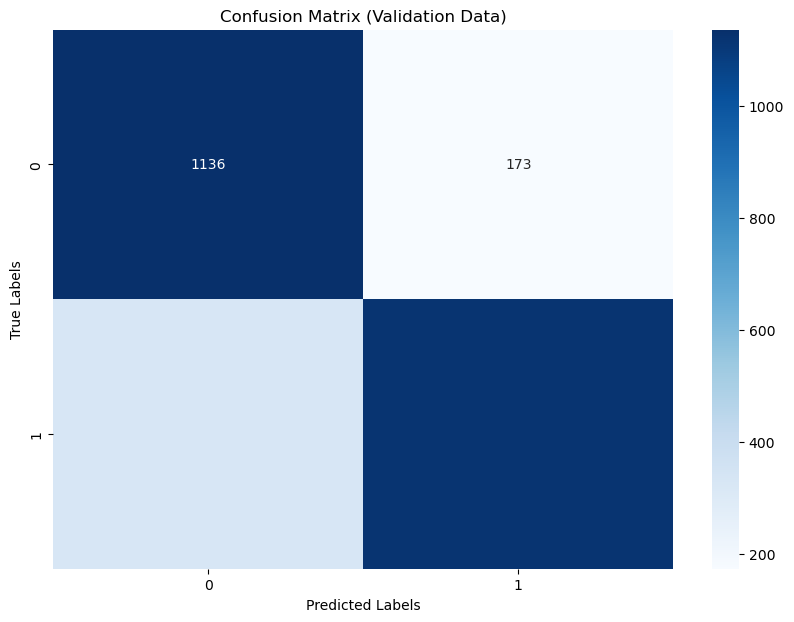

In [56]:
# Initialize sklearn logistic regression model
sklearn_model = LogisticRegression(
    penalty='l1',                 # L1 regularization
    solver='liblinear',           # Solver that supports L1 regularization
    C=1.0,                        # Default regularization strength (inverse of lambda)
    random_state=0                # Ensures reproducibility
)

# Train the model on the training data
sklearn_model.fit(X_train_processed, Y_train)

# Predictions on the training data
y_train_pred = sklearn_model.predict(X_train_processed)
y_train_pred_probs = sklearn_model.predict_proba(X_train_processed)[:, 1]  # Probabilities

# Predictions on the validation data
y_val_pred = sklearn_model.predict(X_val_processed)
y_val_pred_probs = sklearn_model.predict_proba(X_val_processed)[:, 1]  # Probabilities

# Classification Report for Training Data
print("\nClassification Report (Training Data):")
print(classification_report(Y_train, y_train_pred))

# Log Loss for Training Data
train_log_loss = log_loss(Y_train, y_train_pred_probs)
print(f"Log Loss (Training Data): {train_log_loss:.5f}")

# Classification Report for Validation Data
print("\nClassification Report (Validation Data):")
print(classification_report(Y_val, y_val_pred))

# Log Loss for Validation Data
val_log_loss = log_loss(Y_val, y_val_pred_probs)
print(f"Log Loss (Validation Data): {val_log_loss:.5f}")

# Confusion Matrix for Validation Data
conf_matrix = confusion_matrix(Y_val, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.title('Confusion Matrix (Validation Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

---
### Modeling - RandomForest with sklearn


Classification Report (Training Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4036
           1       1.00      1.00      1.00      4234

    accuracy                           1.00      8270
   macro avg       1.00      1.00      1.00      8270
weighted avg       1.00      1.00      1.00      8270

Log Loss (Training Data): 0.10798

Classification Report (Validation Data):
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1309
           1       0.88      0.79      0.84      1448

    accuracy                           0.84      2757
   macro avg       0.84      0.84      0.84      2757
weighted avg       0.84      0.84      0.84      2757

Log Loss (Validation Data): 0.36524


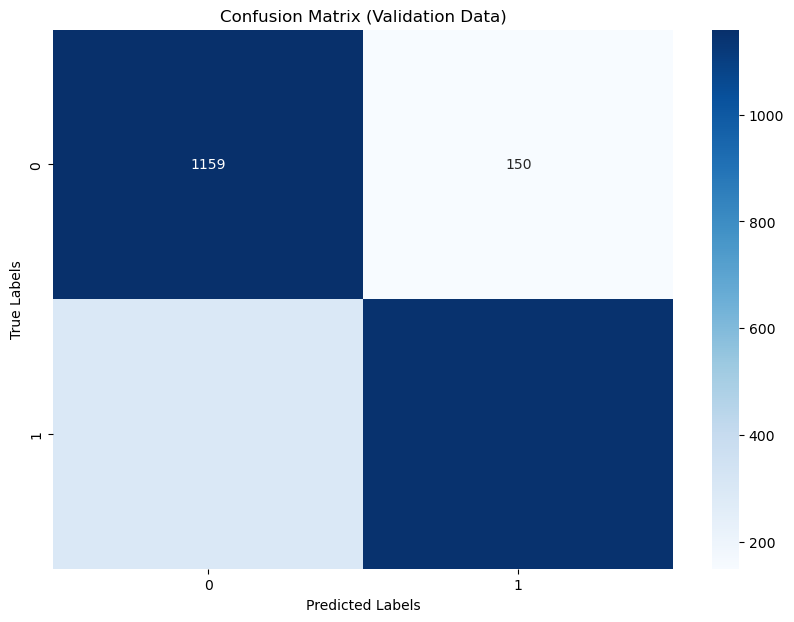

In [57]:
# Initialize RandomForestClassifier with default params
rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)  # Ensure reproducibility and use all available cores

# Train the model on the training data
rf_model.fit(X_train_processed, Y_train)

# Predictions on the training data
y_train_pred = rf_model.predict(X_train_processed)
y_train_pred_probs = rf_model.predict_proba(X_train_processed)[:, 1]  # Probabilities for the positive class

# Predictions on the validation data
y_val_pred = rf_model.predict(X_val_processed)
y_val_pred_probs = rf_model.predict_proba(X_val_processed)[:, 1]  # Probabilities for the positive class

# Classification Report for Training Data
print("\nClassification Report (Training Data):")
print(classification_report(Y_train, y_train_pred))

# Log Loss for Training Data
train_log_loss = log_loss(Y_train, y_train_pred_probs)
print(f"Log Loss (Training Data): {train_log_loss:.5f}")

# Classification Report for Validation Data
print("\nClassification Report (Validation Data):")
print(classification_report(Y_val, y_val_pred))

# Log Loss for Validation Data
val_log_loss = log_loss(Y_val, y_val_pred_probs)
print(f"Log Loss (Validation Data): {val_log_loss:.5f}")

# Confusion Matrix for Validation Data
conf_matrix = confusion_matrix(Y_val, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.title('Confusion Matrix (Validation Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

---
### Modeling - Neural Network

#### <span style="color:chocolate"> Neural Network </span>

In [58]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import tensorflow as tf

# Build a neural network model for Keras Tuner
def build_model_nn(hp):
    """Build a neural network model with hyperparameter tuning, including multiple hidden layers."""
    model = Sequential()
    # Input layer
    model.add(Dense(
        units=hp.Choice('units_input', [64, 128, 256]),  # Tune number of units for the first layer
        activation='relu',
        input_shape=(X_train_processed.shape[1],)
    ))
    # Tune the number of additional hidden layers
    for i in range(hp.Int('num_hidden_layers', 1, 5)):  # Tune between 1 to 3 additional layers
        model.add(Dense(
            units=hp.Choice(f'units_hidden_{i}', [64, 128, 256]),  # Tune number of units for each hidden layer
            activation='relu'
        ))
        model.add(Dropout(hp.Choice(f'dropout_hidden_{i}', [0.2, 0.4, 0.5])))  # Tune dropout for each hidden layer

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01])),  # Tune learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


#### <span style="color:chocolate"> Neural Network tuning with Keras Tuner </span>

Reloading Tuner from my_dir/tune_nn/tuner0.json
Best Hyperparameters:
units: 64
dropout: 0.2
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0

Final Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                3392      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,617
Trainable params: 7,617
Non-trainable params: 0
_______________________________________

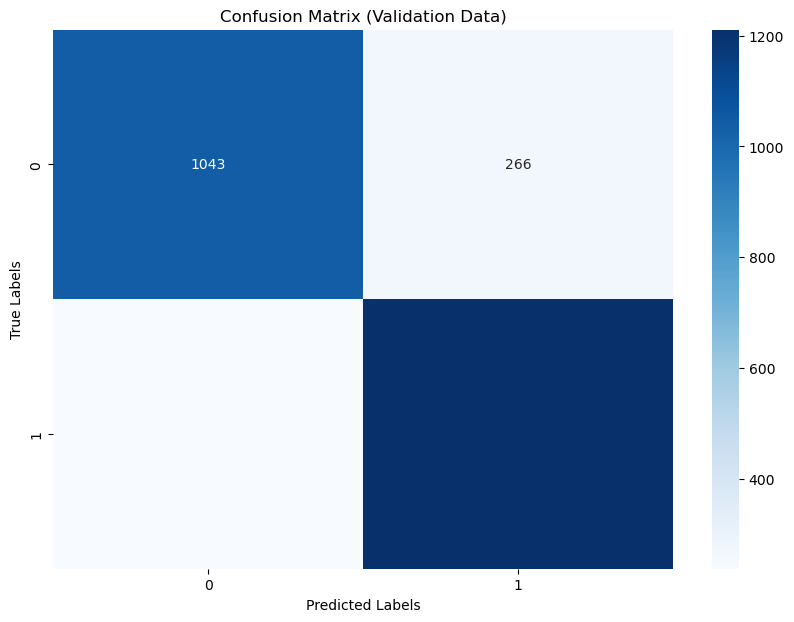

In [59]:
# Initialize Keras Tuner with Hyperband
tuner = kt.Hyperband(
    build_model_nn,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_epochs=50,
    factor=3,                  # Reduction factor
    directory='my_dir',        # Directory to save tuning logs
    project_name='tune_nn'
)

# Search for the best hyperparameters
tuner.search(
    X_train_processed, Y_train,
    epochs=50,
    validation_data=(X_val_processed, Y_val),
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

# Build and compile the final model using the best hyperparameters
final_model_nn = tuner.hypermodel.build(best_hps)

# Output model architecture
print("\nFinal Model Architecture:")
final_model_nn.summary()

# Train the final model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = final_model_nn.fit(
    X_train_processed, Y_train,
    validation_data=(X_val_processed, Y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Output final training metrics
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
print("\nFinal Model Performance:")
print(f"Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

# Predictions on the training data
y_train_pred_probs = final_model_nn.predict(X_train_processed).flatten()  # Probabilities
y_train_pred = (y_train_pred_probs > 0.5).astype(int)  # Binary predictions

# Predictions on the validation data
y_val_pred_probs = final_model_nn.predict(X_val_processed).flatten()  # Probabilities
y_val_pred = (y_val_pred_probs > 0.5).astype(int)  # Binary predictions

# Classification Report for Training Data
print("\nClassification Report (Training Data):")
print(classification_report(Y_train, y_train_pred))

# Log Loss for Training Data
train_log_loss = log_loss(Y_train, y_train_pred_probs)
print(f"Log Loss (Training Data): {train_log_loss:.5f}")

# Classification Report for Validation Data
print("\nClassification Report (Validation Data):")
print(classification_report(Y_val, y_val_pred))

# Log Loss for Validation Data
val_log_loss = log_loss(Y_val, y_val_pred_probs)
print(f"Log Loss (Validation Data): {val_log_loss:.5f}")

# Confusion Matrix for Validation Data
conf_matrix = confusion_matrix(Y_val, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.title('Confusion Matrix (Validation Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

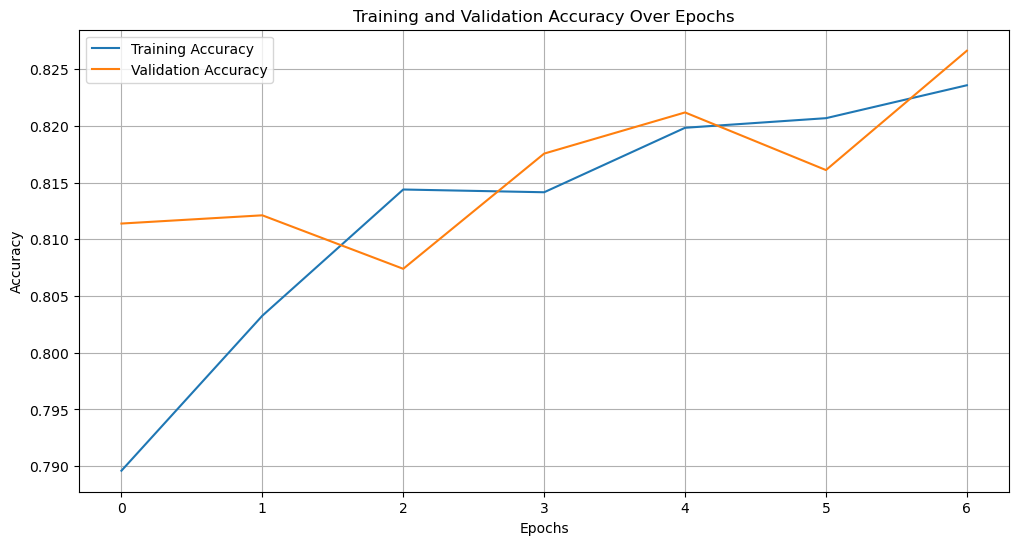

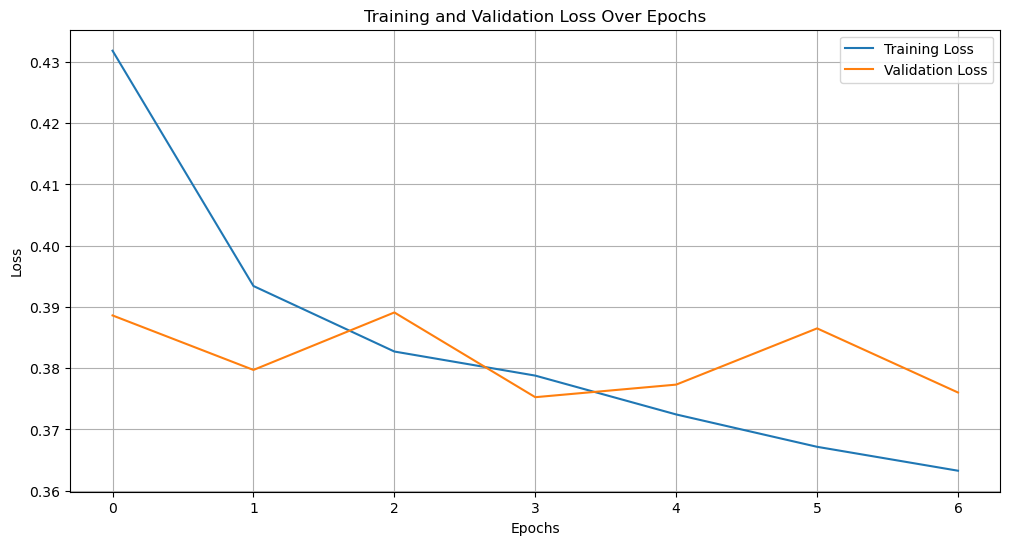

87/87 [==============================] - 0s 228us/step

Final Model Metrics on Training Data:
Accuracy: 0.8176
Precision: 0.8199
Recall: 0.8363
ROC-AUC: 0.9104
Log-Loss: 0.3753


In [60]:
# Visualize training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Visualize training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Validation data predictions
Y_val_pred_probs = final_model_nn.predict(X_val_processed)  # Probabilities
Y_val_pred = (Y_val_pred_probs > 0.5).astype(int)        # Binary predictions (threshold = 0.5)

# Metrics for Training Data
train_accuracy = accuracy_score(Y_val, Y_val_pred)
train_precision = precision_score(Y_val, Y_val_pred)
train_recall = recall_score(Y_val, Y_val_pred)
train_roc_auc = roc_auc_score(Y_val, Y_val_pred_probs)
train_log_loss = log_loss(Y_val, Y_val_pred_probs)

print("\nFinal Model Metrics on Training Data:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")
print(f"Log-Loss: {train_log_loss:.4f}")

---
### Generalization on test data - baseline

In [61]:
# Predict the majority class for the val data
majority_class_val_predictions = np.full(Y_val.shape, majority_class)

# Predicted probabilities for the baseline model
baseline_val_prob = np.full(
    Y_val.shape, 0.1 if majority_class == 1 else 0.9
)

# Predict the majority class for the test data
majority_class_test_predictions = np.full(Y_test.shape, majority_class)

# Predicted probabilities for the baseline model
baseline_test_prob = np.full(
    Y_test.shape, 0.1 if majority_class == 1 else 0.9
)

# Calculate metrics for the baseline model
test_accuracy = accuracy_score(Y_test, majority_class_test_predictions)
test_precision = precision_score(Y_test, majority_class_test_predictions, zero_division=1)  # Avoid precision errors for imbalanced data
test_recall = recall_score(Y_test, majority_class_test_predictions)
test_roc_auc = roc_auc_score(Y_test, baseline_test_prob)
test_log_loss = log_loss(Y_test, baseline_test_prob)

# Display results
print("\nBaseline Model Metrics on Test Data:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")
print(f"Log-Loss: {test_log_loss:.4f}")


Baseline Model Metrics on Test Data:
Accuracy: 0.5187
Precision: 0.5187
Recall: 1.0000
ROC-AUC: 0.5000
Log-Loss: 1.2450


### <span style="color:chocolate"></span> Generalization on test data - Logistics Regression


Logistic Regression Metrics on Test Data:
Accuracy: 0.8165
Precision: 0.8696
Recall: 0.7601
ROC-AUC: 0.9046
Log-Loss: 0.3873

Logistic Regression Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1327
           1       0.87      0.76      0.81      1430

    accuracy                           0.82      2757
   macro avg       0.82      0.82      0.82      2757
weighted avg       0.82      0.82      0.82      2757



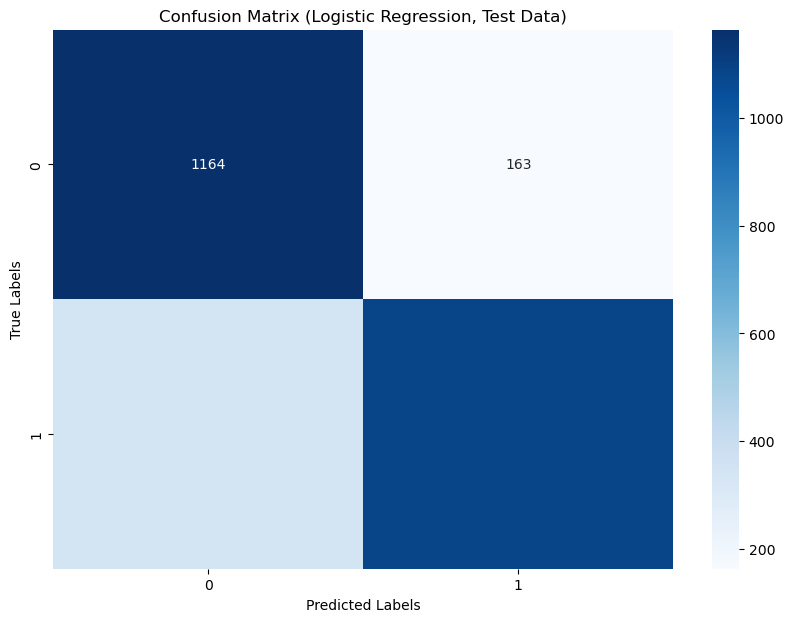

In [62]:
# Logistic Regression: Val data predictions
Y_val_pred_probs_lr = sklearn_model.predict_proba(X_val_processed)[:, 1]  # Probabilities
Y_val_pred_lr = sklearn_model.predict(X_val_processed)                   # Binary predictions

# Logistic Regression: Test data predictions
Y_test_pred_probs_lr = sklearn_model.predict_proba(X_test_processed)[:, 1]  # Probabilities
Y_test_pred_lr = sklearn_model.predict(X_test_processed)                   # Binary predictions

# Metrics for Test Data
test_accuracy_lr = accuracy_score(Y_test, Y_test_pred_lr)
test_precision_lr = precision_score(Y_test, Y_test_pred_lr)
test_recall_lr = recall_score(Y_test, Y_test_pred_lr)
test_roc_auc_lr = roc_auc_score(Y_test, Y_test_pred_probs_lr)
test_log_loss_lr = log_loss(Y_test, Y_test_pred_probs_lr)

print("\nLogistic Regression Metrics on Test Data:")
print(f"Accuracy: {test_accuracy_lr:.4f}")
print(f"Precision: {test_precision_lr:.4f}")
print(f"Recall: {test_recall_lr:.4f}")
print(f"ROC-AUC: {test_roc_auc_lr:.4f}")
print(f"Log-Loss: {test_log_loss_lr:.4f}")

# Classification Report for Test Data
print("\nLogistic Regression Classification Report (Test Data):")
print(classification_report(Y_test, Y_test_pred_lr))

# Confusion Matrix
conf_matrix_lr = confusion_matrix(Y_test, Y_test_pred_lr)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.title('Confusion Matrix (Logistic Regression, Test Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### <span style="color:chocolate"></span> Generalization on test data - RandomForest


Random Forest Metrics on Test Data:
Accuracy: 0.8273
Precision: 0.8756
Recall: 0.7776
ROC-AUC: 0.9224
Log-Loss: 0.3697

Random Forest Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1327
           1       0.88      0.78      0.82      1430

    accuracy                           0.83      2757
   macro avg       0.83      0.83      0.83      2757
weighted avg       0.83      0.83      0.83      2757



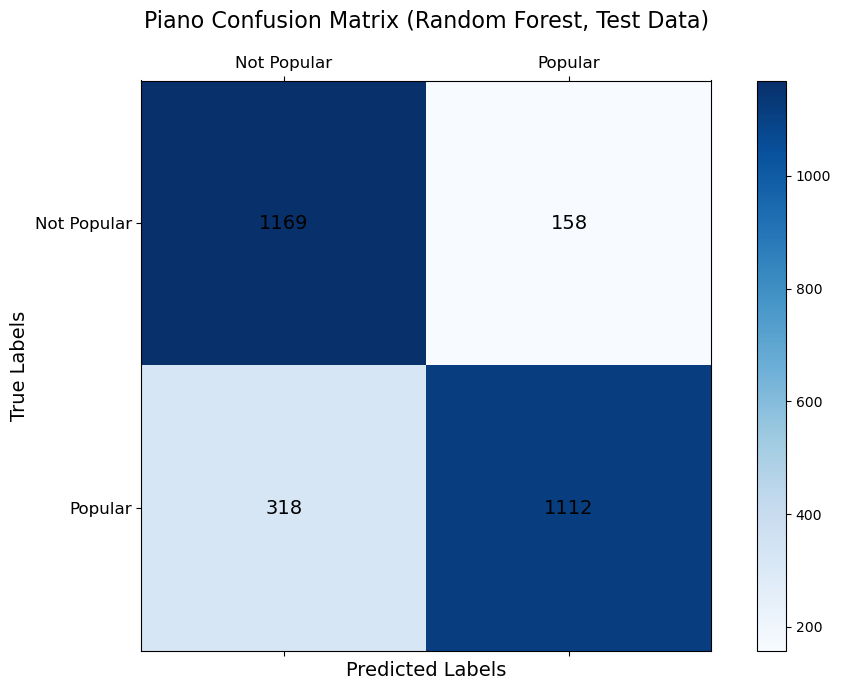

,Feature,Importance
0,instrumentalness,0.072622
1,loudness,0.063618
2,duration_ms,0.063003
3,valence,0.060654
4,energy,0.060022
5,acousticness,0.056234
6,liveness,0.047553
7,speechiness,0.045470
8,tempo,0.044045
9,danceability,0.043561


In [63]:
# Random Forest: Val data predictions val data
Y_val_pred_probs_rf = rf_model.predict_proba(X_val_processed)[:, 1]  # Probabilities
Y_val_pred_rf = rf_model.predict(X_val_processed)                   # Binary predictions

# Random Forest: Test data predictions test data
Y_test_pred_probs_rf = rf_model.predict_proba(X_test_processed)[:, 1]  # Probabilities
Y_test_pred_rf = rf_model.predict(X_test_processed)                   # Binary predictions

# Metrics for Test Data
test_accuracy_rf = accuracy_score(Y_test, Y_test_pred_rf)
test_precision_rf = precision_score(Y_test, Y_test_pred_rf)
test_recall_rf = recall_score(Y_test, Y_test_pred_rf)
test_roc_auc_rf = roc_auc_score(Y_test, Y_test_pred_probs_rf)
test_log_loss_rf = log_loss(Y_test, Y_test_pred_probs_rf)

print("\nRandom Forest Metrics on Test Data:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Precision: {test_precision_rf:.4f}")
print(f"Recall: {test_recall_rf:.4f}")
print(f"ROC-AUC: {test_roc_auc_rf:.4f}")
print(f"Log-Loss: {test_log_loss_rf:.4f}")

# Classification Report for Test Data
print("\nRandom Forest Classification Report (Test Data):")
print(classification_report(Y_test, Y_test_pred_rf))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(Y_test, Y_test_pred_rf)

# Plot the matrix
fig, ax = plt.subplots(figsize=(10, 7))
ax.matshow(conf_matrix_rf, cmap="Blues")  # Display confusion matrix as an image

# Add title and labels
plt.title('Piano Confusion Matrix (Random Forest, Test Data)', pad=20, fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks([0, 1], ['Not Popular', 'Popular'], fontsize=12)  # Set custom x-tick labels
plt.yticks([0, 1], ['Not Popular', 'Popular'], fontsize=12)  # Set custom y-tick labels

# Annotate the cells with the numbers (I couldn't get standard confusion matrix to print the numbers on all 4 squares)
for i in range(conf_matrix_rf.shape[0]):  # Rows
    for j in range(conf_matrix_rf.shape[1]):  # Columns
        ax.text(
            x=j, y=i, s=conf_matrix_rf[i, j],  # Text annotation
            va='center', ha='center', fontsize=14, color="black"  # Text properties
        )

# Adjust layout and show the plot
plt.colorbar(ax.matshow(conf_matrix_rf, cmap="Blues"))  # Add color bar for clarity
plt.tight_layout()
plt.show()

# rf_model coefficients
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
# Print rf_model coefficients in a formatted table using Pandas
importances_df = pd.DataFrame({
    'Feature': X_train_processed.columns[indices],
    'Importance': importances[indices]
})
importances_df

### <span style="color:chocolate"></span> Generalization on test data - Neural Network

87/87 [==============================] - 0s 215us/step

Final Model Metrics on Test Data:
Accuracy: 0.8139
Precision: 0.8186
Recall: 0.8238
ROC-AUC: 0.9053
Log-Loss: 0.3863

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1327
           1       0.82      0.82      0.82      1430

    accuracy                           0.81      2757
   macro avg       0.81      0.81      0.81      2757
weighted avg       0.81      0.81      0.81      2757



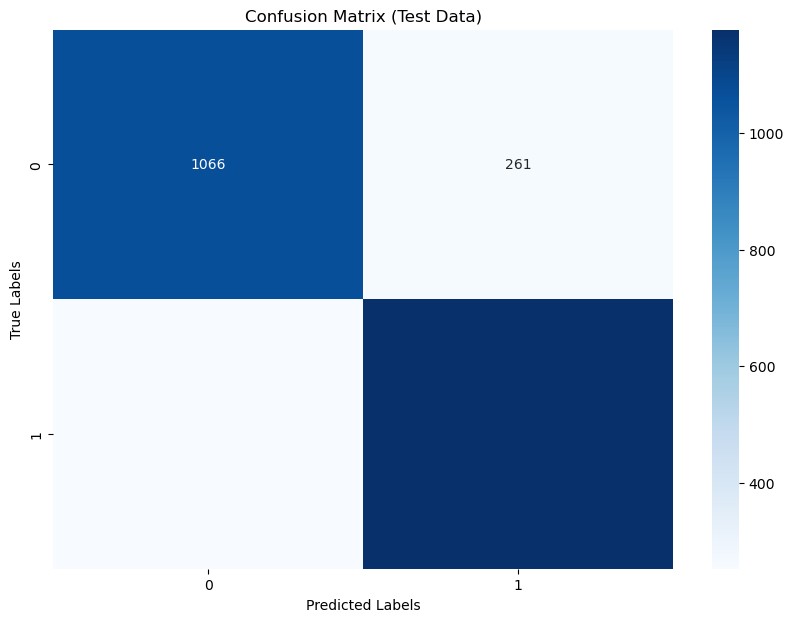

In [64]:
# Val data Predictions
Y_val_pred_probs = final_model_nn.predict(X_val_processed)  # Probabilities
Y_val_pred = (Y_val_pred_probs > 0.5).astype(int)        # Binary predictions (threshold = 0.5)

# Test data predictions
Y_test_pred_probs = final_model_nn.predict(X_test_processed)  # Probabilities
Y_test_pred = (Y_test_pred_probs > 0.5).astype(int)        # Binary predictions (threshold = 0.5)

# Metrics for Test Data
test_accuracy = accuracy_score(Y_test, Y_test_pred)
test_precision = precision_score(Y_test, Y_test_pred)
test_recall = recall_score(Y_test, Y_test_pred)
test_roc_auc = roc_auc_score(Y_test, Y_test_pred_probs)
test_log_loss = log_loss(Y_test, Y_test_pred_probs)

print("\nFinal Model Metrics on Test Data:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")
print(f"Log-Loss: {test_log_loss:.4f}")

# Classification Report for Test Data
print("\nClassification Report on Test Data:")
print(classification_report(Y_test, Y_test_pred))

# Confusion Matrix for Test Data
conf_matrix = confusion_matrix(Y_test, Y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.title('Confusion Matrix (Test Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### <span style="color:chocolate"></span> AUC scores, ROC curves on Val data

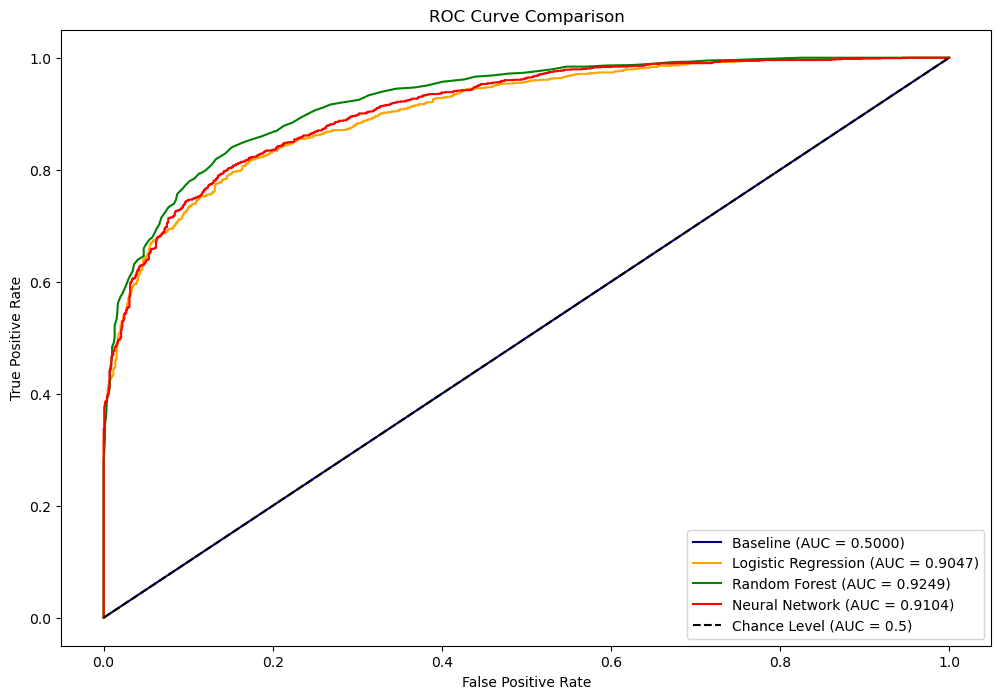

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate AUC scores for each model using val data
auc_baseline = roc_auc_score(Y_val, baseline_val_prob)
auc_lr = roc_auc_score(Y_val, Y_val_pred_probs_lr)
auc_rf = roc_auc_score(Y_val, Y_val_pred_probs_rf)
auc_nn = roc_auc_score(Y_val, Y_val_pred_probs)


# Calculate ROC Curves
fpr_baseline, tpr_baseline, _ = roc_curve(Y_val, baseline_val_prob)
fpr_lr, tpr_lr, _ = roc_curve(Y_val, Y_val_pred_probs_lr)
fpr_rf, tpr_rf, _ = roc_curve(Y_val, Y_val_pred_probs_rf)
fpr_nn, tpr_nn, _ = roc_curve(Y_val, Y_val_pred_probs)


# Plot ROC Curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline (AUC = {auc_baseline:.4f})", color='navy')
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.4f})", color='orange')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})", color='green')
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc_nn:.4f})", color='red')


# Add Chance Level Line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Chance Level (AUC = 0.5)")

# Add labels, legend, and grid
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### <span style="color:chocolate"></span> AUC scores, ROC curves on Test data

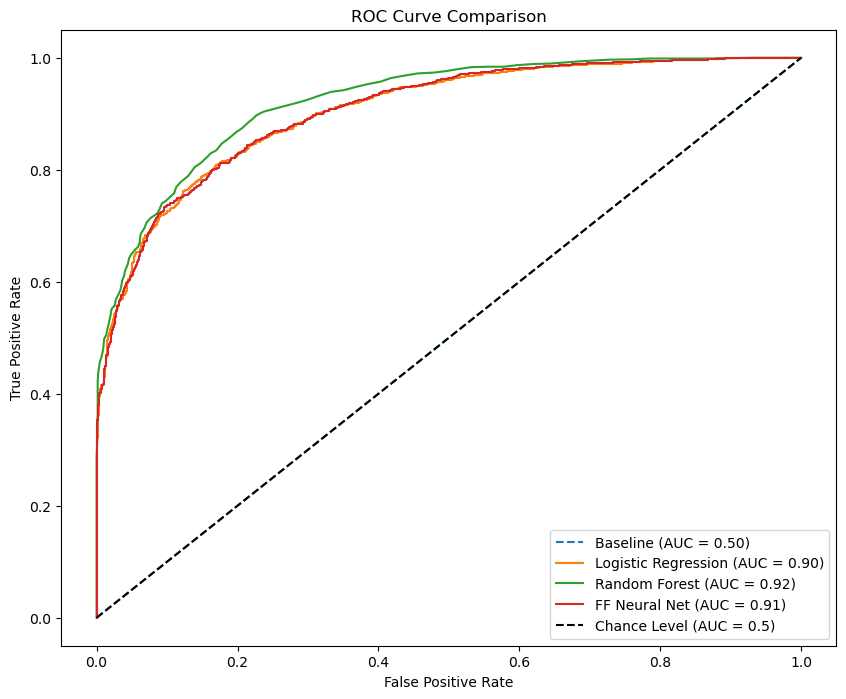

In [66]:
# Calculate AUC scores for each model
baseline_roc_auc = roc_auc_score(Y_test, baseline_test_prob)
logistic_roc_auc = roc_auc_score(Y_test, Y_test_pred_probs_lr)
random_forest_roc_auc = roc_auc_score(Y_test, Y_test_pred_probs_rf)
nn_roc_auc = roc_auc_score(Y_test, Y_test_pred_probs)

# Calculate ROC Curves
baseline_fpr, baseline_tpr, _ = roc_curve(Y_test, baseline_test_prob)
logistic_fpr, logistic_tpr, _ = roc_curve(Y_test, Y_test_pred_probs_lr)
rf_fpr, rf_tpr, _ = roc_curve(Y_test, Y_test_pred_probs_rf)
nn_fpr, nn_tpr, _ = roc_curve(Y_test, Y_test_pred_probs)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(baseline_fpr, baseline_tpr, label=f"Baseline (AUC = {baseline_roc_auc:.2f})", linestyle="--")
plt.plot(logistic_fpr, logistic_tpr, label=f"Logistic Regression (AUC = {logistic_roc_auc:.2f})", linestyle="-")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {random_forest_roc_auc:.2f})", linestyle="-")
plt.plot(nn_fpr, nn_tpr, label=f"FF Neural Net (AUC = {nn_roc_auc:.2f})", linestyle="-")

# Add Chance Level Line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Chance Level (AUC = 0.5)")

# Add labels, legend, and grid
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()